# Benchmark face detection

## Install

In [1]:
%pip install dlib face-alignment retinaface_pytorch > /dev/null

ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.4.2 which is incompatible.


## Download

### Data

In [2]:
!curl -o t0.jpg https://i.imgur.com/h7YksQp.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  118k  100  118k    0     0  3201k      0 --:--:-- --:--:-- --:--:-- 3201k


In [3]:
app_ids = [1271300, 1323710, 554180, 1449370]
base_url = 'https://cdn.cloudflare.steamstatic.com/steam/apps/'

for i, app_id in enumerate(app_ids, start=1):
  fname = 't{}.jpg'.format(i)
  !curl -o {fname} {base_url}{app_id}/library_600x900.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  103k  100  103k    0     0  1782k      0 --:--:-- --:--:-- --:--:-- 1782k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 79836  100 79836    0     0  1012k      0 --:--:-- --:--:-- --:--:-- 1012k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 77608  100 77608    0     0  2368k      0 --:--:-- --:--:-- --:--:-- 2368k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 71944  100 71944    0     0   375k      0 --:--:-- --:--:-- --:--:--  375k


### Models

In [4]:
import dlib

dlib_detector = dlib.get_frontal_face_detector()

In [5]:
import face_alignment

fa_detector = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D,
                                           face_detector='sfd')

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-11f355bf06.pth.tar" to /root/.cache/torch/hub/checkpoints/2DFAN4-11f355bf06.pth.tar


In [6]:
from retinaface.pre_trained_models import get_model

rf_detector = get_model("resnet50_2020-07-20", 
                     max_size = 840,
                     device='cuda')
rf_detector.eval()

Downloading: "https://github.com/ternaus/retinaface/releases/download/0.01/retinaface_resnet50_2020-07-20-f168fae3c.zip" to /root/.cache/torch/hub/checkpoints/retinaface_resnet50_2020-07-20-f168fae3c.zip


/usr/local/lib/python3.6/dist-packages/torch/hub.py:483: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


## Detect faces

In [60]:
from skimage import io

fname = 't3.jpg'
img = io.imread(fname)

### `dlib`

In [61]:
dets, scores, idx = dlib_detector.run(img, 
                                      upsample_num_times = 1,
                                      adjust_threshold = 0.0)

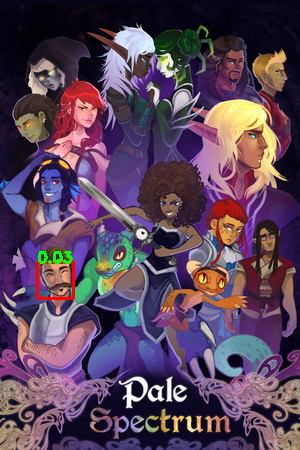

In [62]:
import cv2
from google.colab.patches import cv2_imshow

image = img.copy()

for rect, score in zip(dets, scores):
  cv2.rectangle(image, 
                (rect.left(), rect.top()), 
                (rect.right(), rect.bottom()),
                (255, 0, 0), 
                2)
  cv2.putText(image, 
              '{:.2f}'.format(score), 
              (rect.left(), rect.top()),
              cv2.FONT_HERSHEY_SIMPLEX, 
              0.5, 
              (0, 255, 0),
              2)

cv2_imshow(image[:,:,::-1])

### `face_alignment`

In [63]:
dets = fa_detector.face_detector.detect_from_image(img[..., ::-1].copy())

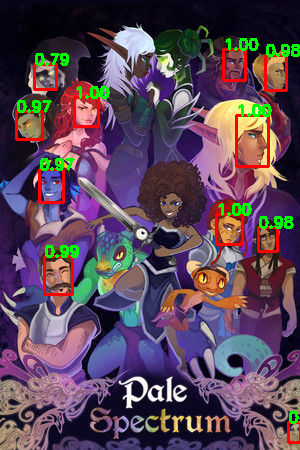

In [64]:
import cv2
from google.colab.patches import cv2_imshow

image = img.copy()

for rect in dets:
  (x, y, xM, yM) = rect[:4]
  cv2.rectangle(image, 
                (x, y),
                (xM, yM),
                (255, 0, 0),
                2)
  score = rect[-1]
  cv2.putText(image, 
              '{:.2f}'.format(score), 
              (x, y),
              cv2.FONT_HERSHEY_SIMPLEX, 
              0.5, 
              (0, 255, 0),
              2)
  
cv2_imshow(image[:,:,::-1])

### `retinaface`

In [67]:
dets = rf_detector.predict_jsons(img,
                                 confidence_threshold=0.08,
                                 nms_threshold=0.01)

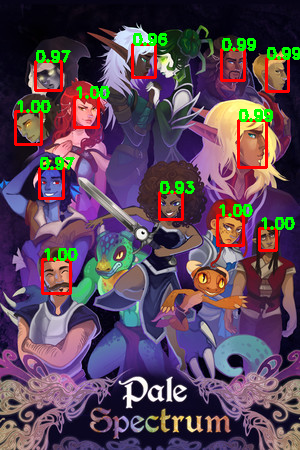

In [68]:
import cv2
from google.colab.patches import cv2_imshow

image = img.copy()

for rect in dets:
  (x, y, xM, yM) = rect['bbox']
  cv2.rectangle(image, 
                (x, y), 
                (xM, yM),
                (255, 0, 0), 
                2)
  score = rect['score']
  cv2.putText(image, 
              '{:.2f}'.format(score), 
              (x, y),
              cv2.FONT_HERSHEY_SIMPLEX, 
              0.5, 
              (0, 255, 0),
              2)  
  
cv2_imshow(image[:,:,::-1])